# Tweet sentinent analysis - Classification

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
nltk.download('punkt')
from sklearn.linear_model import LogisticRegression


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [89]:
train_df = pd.read_csv('./train_text.txt', delimiter = "\t", header=None)
train_tags_df = pd.read_csv('./train_tags.txt', delimiter = "\t", header=None)

stopwords = pd.read_csv('./polish.stopwords.txt', delimiter = "\t", header=None)[0].values.tolist()

train_df['tag'] = train_tags_df

train_df.columns = ['text', 'tag']

test_df = pd.read_csv('./test_text.txt', delimiter = "\t", header=None)
test_tags_df = pd.read_csv('./test_tags.txt', delimiter = "\t", header=None)

test_df['tag'] = test_tags_df

test_df.columns = ['text', 'tag']

train_df.head()

,text,tag
0,Dla mnie faworytem do tytułu będzie Cracovia. ...,0
1,@anonymized_account @anonymized_account Brawo ...,0
2,"@anonymized_account @anonymized_account Super,...",0
3,@anonymized_account @anonymized_account Musi. ...,0
4,"Odrzut natychmiastowy, kwaśna mina, mam problem",0


In [90]:
print(sum(train_df['tag'] == 1), sum(train_df['tag'] == 0))
print(sum(test_df['tag'] == 1), sum(test_df['tag'] == 0))
train_df['tag'].skew(), test_df['tag'].skew()

851 9190
134 866


(2.9823343028874767, 2.1520479253777736)

Text(0.5, 1.0, 'Label class distribution')

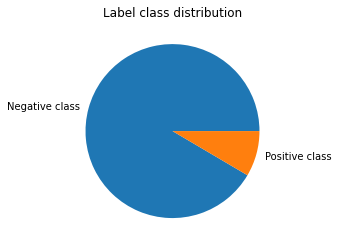

In [91]:
plt.pie([sum(train_df['tag'] == 0), sum(train_df['tag'] == 1)], labels=['Negative class', 'Positive class'])
plt.title('Label class distribution')

## Introduction

The dataset is from http://2019.poleval.pl/index.php/tasks/task6 / http://2019.poleval.pl/. The task there was to distinguish tweets between harmful ones and non-harmful.

The dataset contains ``text`` and ``tag``. Tag is the target variable, where 0 means non-harmful and 1 means harmful.

The biggest flaw of the dataset is that it is skewed. Amongst 10000 training samples, only 10% of them are actually labeled as harmful. The skew coefficient is 2.98.

For testing the model, there is other provided dataset (no need for split) of 1000 samples with the similar skewity and imbalance.

## Data preparation

During tokenization, numbers are removed, but also punctuation, @user mentions, and tokens that are not alphanumerical (like emojis). Ideally, lemmatization and more advanced word stemming would be recommended, but I skipped this step for simplicity.

Then CountVectorizer is used.

In [92]:
from nltk.tokenize.casual import TweetTokenizer
!pip install pystempel
import re
from stempel import StempelStemmer

t = TweetTokenizer()
stemmer = StempelStemmer.polimorf()

def process_text(row):
  sentence=str(row)
  sentence = sentence.lower()
  sentence=sentence.replace('{html}',"") 
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', sentence)
  rem_url=re.sub(r'http\S+', '',cleantext)
  rem_num = re.sub('[0-9]+', '', rem_url)
  tokens = t.tokenize(row)
  tokens = [w.lower() for w in tokens]
  tokens = [stemmer.stem(x) for x in tokens if (x not in string.punctuation and x != "@anonymized_account" and "http" not in x and x.isnumeric() is False and x.isalpha())]

  return ' '.join(map(str, tokens))

Loading: 100%|██████████| 11368252/11368252 [00:12<00:00, 924166.43bytes/s] 


In [93]:
train_df["text_post"] = train_df["text"].apply(process)

train_df.head()

,text,tag,text_post
0,Dla mnie faworytem do tytułu będzie Cracovia. ...,0,dlativus miąć faworyt dojciec tytuł być cracov...
1,@anonymized_account @anonymized_account Brawo ...,0,brawo ty daria kibic mój być nativus dobry i zły
2,"@anonymized_account @anonymized_account Super,...",0,super polski premiera składać kwiat nativus gr...
3,@anonymized_account @anonymized_account Musi. ...,0,muszy inny drogi n mieć
4,"Odrzut natychmiastowy, kwaśna mina, mam problem",0,odrzut natychmiastowy kwaśny mina mieć problem


## Training

In [94]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = CountVectorizer()

X_train = vectorizer.fit_transform(train_df.text_post)
y_train = train_df.tag

model = LogisticRegression(max_iter=10000).fit(X=X_train, y=y_train)

### The top 10 of most significants words

In [95]:
zipped = list(zip(model.coef_.flatten(), vectorizer.get_feature_names_out()))

sortedd = sorted(zipped, key= lambda x: x[0])

# not significant, the most significant/hateful
sortedd[:10], sortedd[-10:]

([(-1.3245198332674348, 'duży'),
  (-1.2304873104430514, 'sędzia'),
  (-1.0919099051644323, 'pytanie'),
  (-1.0085447389592277, 'choć'),
  (-0.9513152938700037, 'wszystek'),
  (-0.9456378610507146, 'liga'),
  (-0.9153360258668874, 'dzisiać'),
  (-0.9072597193003968, 'meczeć'),
  (-0.8992261279876894, 'fajny'),
  (-0.889078112826876, 'kilka')],
 [(1.9679937719755323, 'pisdzielstwo'),
  (1.995498072582821, 'śmierdzieć'),
  (2.007981103842983, 'idiota'),
  (2.11507465912758, 'pisowski'),
  (2.269983518616505, 'kutas'),
  (2.312466853260933, 'mózg'),
  (2.510318396228816, 'pedofil'),
  (2.6288054271948518, 'debil'),
  (2.6644460405153527, 'gnój'),
  (2.758449317575129, 'pajac')])

## Predicting

### Score of the model

In [96]:
from sklearn.metrics import recall_score
from sklearn.metrics import balanced_accuracy_score

test_df["text_post"] = test_df["text"].apply(process)

X_test = vectorizer.transform(test_df.text_post)
y_test = test_df.tag

y_pred = model.predict(X_test)

# metrics
model.score(X_test, y_test), balanced_accuracy_score(y_test, y_pred), recall_score(y_test, y_pred)

(0.881, 0.5685860535658888, 0.1417910447761194)

### Confusion matrix

              precision    recall  f1-score   support

           0       0.88      1.00      0.94       866
           1       0.83      0.14      0.24       134

    accuracy                           0.88      1000
   macro avg       0.85      0.57      0.59      1000
weighted avg       0.87      0.88      0.84      1000



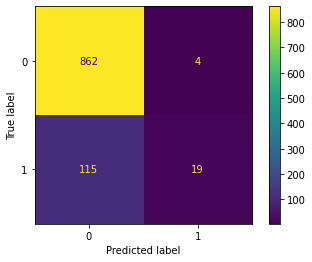

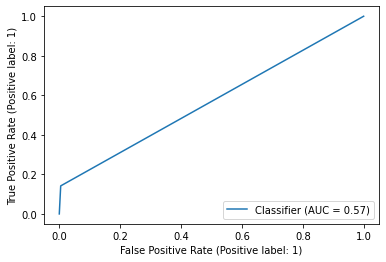

In [97]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import classification_report

# metrics
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
RocCurveDisplay.from_predictions(y_test, y_pred)

### Interpretation of the metrics

The accuracy may be not the best metric for the imbalanced datasets. Since, in this particular case:

The testing set contains 

In [98]:
print('total: ', len(test_df)), print('positive samples: ', sum(test_df['tag'] == 1)), print('negative samples: ', sum(test_df['tag'] == 0))

total:  1000
positive samples:  134
negative samples:  866


(None, None, None)

If the model classify all samples as the negative ones, we still get 866/1000 so 0.866 accuracy.

Above I provided additonal metrics.

#### ROC AUC curve

As seen on the plot, AUC is 0.55. We could plot additional diagonal (45 degree) line which would represent a "random classifier" (so the 0.5 AUC score). As we can see, our logistic regression model is just slighty above the hypothethical diagonal line, as it performs slighty better than a random classifier.


#### Confusion matrix

It is pretty self explanatory, only 15 samples were classified true positives and 119 false negatives. Here we can see, how bad the classifier really is. 

Recall and precision are calculated from the confusion matrix data.

#### Recall and precision

Recall is the metric on which we should focus. As on sklearn docs:
> The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

> The best value is 1 and the worst value is 0.

If that's so, then in this particular case, recall is the most important metric because not detecting harmful tweet "costs" us more than labeling non-harmful tweet as harmful.

Recall is 0.11, so it's not the best.

## Multinomial Naive Bayes Classifier

I could find out a way to improve the perfomance of the model. We will use a Multinomial Naive Bayes Classifier and before that we will perform over-sampling of the minority class. The over-sampling is only applied to the training dataset.

In [99]:
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE


### Pipeline creation

In [100]:
textclassifier =Pipeline([
  ('vect', TfidfVectorizer(max_features=1500, stop_words=stopwords)),
  ('smote', SMOTE(sampling_strategy='minority', random_state=12)),
  ('mnb', MultinomialNB())
])

### Training

In [101]:
textclassifier.fit(train_df.text_post, y_train)

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=1500,
                                 stop_words=['a', 'aby', 'ach', 'acz',
                                             'aczkolwiek', 'aj', 'albo', 'ale',
                                             'alez', 'ależ', 'ani', 'az', 'aż',
                                             'bardziej', 'bardzo', 'beda',
                                             'bedzie', 'bez', 'deda', 'będą',
                                             'bede', 'będę', 'będzie', 'bo',
                                             'bowiem', 'by', 'byc', 'być',
                                             'byl', 'byla', ...])),
                ('smote', SMOTE(random_state=12, sampling_strategy='minority')),
                ('mnb', MultinomialNB())])

### Predicting

#### Score

In [102]:
y_pred = textclassifier.predict(test_df.text_post)

textclassifier.score(test_df.text_post, y_test), balanced_accuracy_score(y_test, y_pred), recall_score(y_test, y_pred)

(0.783, 0.7075505842611423, 0.6044776119402985)

#### Confusion matrix

              precision    recall  f1-score   support

           0       0.93      0.81      0.87       866
           1       0.33      0.60      0.43       134

    accuracy                           0.78      1000
   macro avg       0.63      0.71      0.65      1000
weighted avg       0.85      0.78      0.81      1000



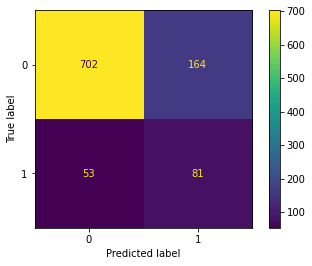

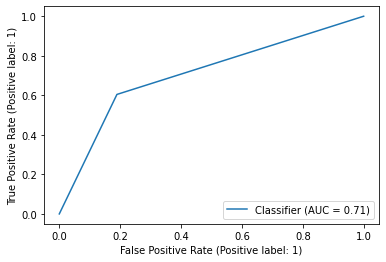

In [103]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay

# metrics
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
RocCurveDisplay.from_predictions(y_test, y_pred)


In [104]:
X_res, y_res = SMOTE(sampling_strategy='minority', random_state=12).fit_resample(TfidfVectorizer().fit_transform(train_df.text_post), y_train)

In [105]:
from collections import Counter

y_res.skew(), Counter(y_res), Counter(y_train) # to show the effect of oversampling, now the resampled dataset contains way more samples labeled as positive than in original dataset and its skew now is 0

(0.0, Counter({0: 9190, 1: 9190}), Counter({0: 9190, 1: 851}))

## Summary

There is a significant increase in recall score after applying oversampling and MNB (I tested LogisticRegression as well. It got better performance after oversampling, however, still worse than MNB). Decision trees were also tested and they performed worse than MNB.

Just analysis of the confusion matrix gives us insight that the new model correctly labels more than a half actually harmful tweets.

Recall increased from 0.11 previously to 0.60.

AUC score increased to 0.77 which is considered "decent". Training set got a score of 0.9 AUC.

So due to that, I still think poor perfomance of the model is related to the dataset imbalance. The approach in this notebook may be just too simple for this problem. However, I am still not satisfified by the model perfomance and I wouldn't recognize it as "good" personally. 

Stemming and/or lemmization of the words is a challenge itself, because while there are ready and easy to use libraries for the English language - the Polish language is not so well supported. The stemming library that I used sometimes gives strange results (like replacing a person's name with something else).

On the other hand, we can think about what is a harmful/hate speech? Is it well defined or interpretation of this term comes to an invididual? In the end, all tweets in this dataset had to be labeled by some human. While for one, the tweet may be offensive and harmful, the other may view it as non-harmful. While perceived by one as hateful, it does mean the tweet is actually hateful.

I conclude this notebook and exercise as finished since I can't increase perfomance of the model anymore. Now we can see, how skewity can change our model and why we should not rely just at the accuracy score itself.

In a contrast to Amazon Reviews dataset, where accuracy/AUC score (in a exercise we talked about in class) was better, the people on twitter does not care about proper grammar as in Amazon reviews. The twitter speech is less formal and all of this surely has impact on the model perfomance.